In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [3]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [4]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:14<00:00,  7.30s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [7]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [9]:
input_shape = (224,224, 3)
batch_size = 32

In [10]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [12]:
pretrained_resnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
pretrained_resnet50_model.trainable = False

2022-03-15 18:04:09.768474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 18:04:09.926563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 18:04:09.927250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 18:04:09.928852: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [13]:
def print_layer_trainable():
    for layer in pretrained_resnet50_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# for layer in pretrained_inceptionv3_model.layers[-20:]:
#     layer.trainable = True

# print_layer_trainable()

print('Num layers, ', len(pretrained_resnet50_model.layers))

Num layers,  175


In [14]:
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU

model_resnet50 = tf.keras.Sequential([
                             pretrained_resnet50_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                             ])

model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
#     optimizer=Adam(learning_rate=1e-5),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 126,350,209
Trainable params: 102,762,497
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
#     monitor='val_loss',
    factor=0.6,
    patience=3,
    min_lr=1e-6,
#     min_delta=0.000001,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )

filename = 'resnet50.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
#     monitor='val_loss',
    verbose=1,
    save_best_only=True
)

# history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])
history = model_resnet50.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])


2022-03-15 18:04:14.950264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-15 18:04:18.482392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 17s 177ms/step - loss: 1.0074 - accuracy: 0.5846 - val_loss: 0.5139 - val_accuracy: 0.7344

Epoch 00001: val_accuracy improved from -inf to 0.73438, saving model to resnet50.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
48/48 [==============================] - 8s 157ms/step - loss: 0.5618 - accuracy: 0.7096 - val_loss: 0.4797 - val_accuracy: 0.7839

Epoch 00002: val_accuracy improved from 0.73438 to 0.78385, saving model to resnet50.h5
Epoch 3/50
48/48 [==============================] - 8s 159ms/step - loss: 0.5178 - accuracy: 0.7533 - val_loss: 0.4662 - val_accuracy: 0.7786

Epoch 00003: val_accuracy did not improve from 0.78385
Epoch 4/50
48/48 [==============================] - 7s 153ms/step - loss: 0.4751 - accuracy: 0.7656 - val_loss: 0.4871 - val_accuracy: 0.7370

Epoch 00004: val_accuracy did not improve from 0.78385
Epoch 5/50
48/48 [==============================] - 7s 147ms/step - loss: 0.4758 - accuracy: 0.7669 - val_loss: 0.4217 - val_accuracy: 0.8099

Epoch 00005: val_accuracy improved from 0.78385 to 0.80990, saving model to resnet50.h5
Epoch 6/50
48/48 [==============================] - 8s 169ms/step - loss: 0.4885 - accuracy: 0.7559 - val_loss: 0.4529 - val_accuracy: 0.7760


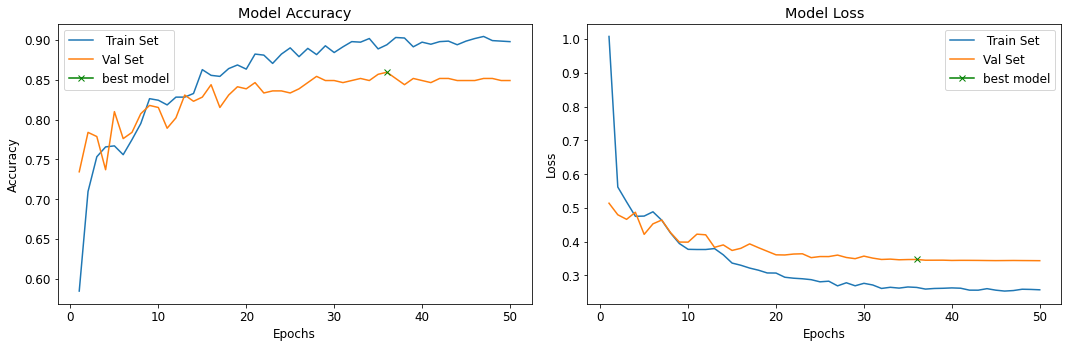

In [21]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
# plt.plot(36, 0.9766, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
plt.plot(36, 0.8594, marker="x", color="g", label="best model")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
# plt.plot(28, 0.0750, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
plt.plot(36, 0.3474, marker="x", color="g", label="best model")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import load_model
saved_model = load_model('./resnet50.h5', compile = False)

saved_model.compile(
    optimizer=Adam(learning_rate=1e-4),
#     optimizer=Adam(learning_rate=1e-5),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# validation set
predictions = saved_model.predict(X_val / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]
# predictions = [1 if x>0.4 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val / 255, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.8652, Val: 0.8307
Validation Accuracy = 0.8307
Precision: 0.899371
Recall: 0.744792
F1 score: 0.814815
Cohens kappa: 0.661458
ROC AUC: 0.830729
[[176  16]
 [ 49 143]]
True positive: 143 , True negative: 176 , False positive: 16 , False negative: 49


Train: 0.8652, Test: 0.8250
Test Accuracy = 0.8250
Precision: 0.886139
Recall: 0.745833
F1 score: 0.809955
Cohens kappa: 0.650000
ROC AUC: 0.825000
[[217  23]
 [ 61 179]]
True positive: 179 , True negative: 217 , False positive: 23 , False negative: 61
Sensitivity: 0.7458
Specificity: 0.9042


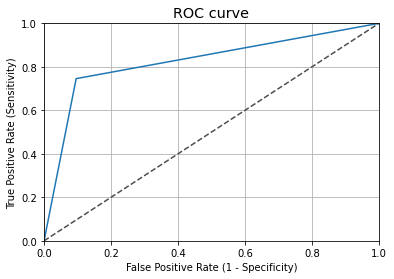

In [19]:
# test set (best)
predictions = saved_model.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Train: 0.8757, Test: 0.8354
Test Accuracy = 0.8354
Precision: 0.881517
Recall: 0.775000
F1 score: 0.824834
Cohens kappa: 0.670833
ROC AUC: 0.835417
[[215  25]
 [ 54 186]]
True positive: 186 , True negative: 215 , False positive: 25 , False negative: 54
Sensitivity: 0.7750
Specificity: 0.8958


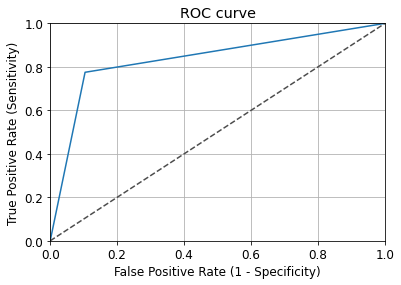

In [20]:
# test set (full epoch)
predictions = model_resnet50.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model_resnet50.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = model_resnet50.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)